# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt

# Configuration

In [3]:
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
#'/glade/work/mcginnis/DCA/data/gen/final/glm/hist/prec.hist.MPI-ESM-LR.GLM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
#'/glade/work/mcginnis/DCA/data/gen/final/glm/rcp85/prec.rcp85.MPI-ESM-LR.GLM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc']


### Load model output data

In [4]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




In [5]:
# # Surface region of interest: SGP
# dv2[0].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).plot()

### Load UATM data

In [6]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))



In [7]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [8]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):

        mpr = rainsignal[ii]
        if mpr["time.month"] == 5:    # May

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Plot routines

In [9]:
import matplotlib.pyplot as plt

# plot average rain inputs
def plot_8v(isample, modelname, vmin, vmax):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
    fig, axarr = plt.subplots(1, 8, figsize = (20,20))
    for ii in range(8):
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()

def plot_8v_autoscale(isample, modelname):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20))
    for ii in range(8):
        #axarr[ii].set_title("Subplot row", fontsize=16)
        plot = axarr[ii].imshow(isample[ii][::-1,:], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


In [10]:
from os.path import basename

def plot_models(mpr_min, mpr_max, sigfiles):     
    # find min/max values for entire sigfiles set
    vmin = 9999*np.ones(8) 
    vmax = -9999*np.ones(8) 
    for sigfile in sigfiles:        
        if sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']
        avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
        vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
        vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]
    
    # Use 0 as minimum value for Q
    vmin[2] = 0. 

    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))


    # plots 
    for sigfile in sigfiles:
        if sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")

        # plot
        rainsignal = xr.open_dataset(sigfile)['prec']
        avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
        sigfilename = basename(sigfile)
        print ("days:", count, ", model:", sigfilename)
        rowtitle = '.'.join(sigfilename.split('.')[0:4])
        plot_8v(avginput, rowtitle.upper(), vmin, vmax)


# Run over different models

### MPI + x

In [11]:
sigfiles = mpi_sigfiles # see configuration cell at beginning of notebook

# Dry day plots (hist and rcp85)

dry: hist
days: 358 , model: prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc


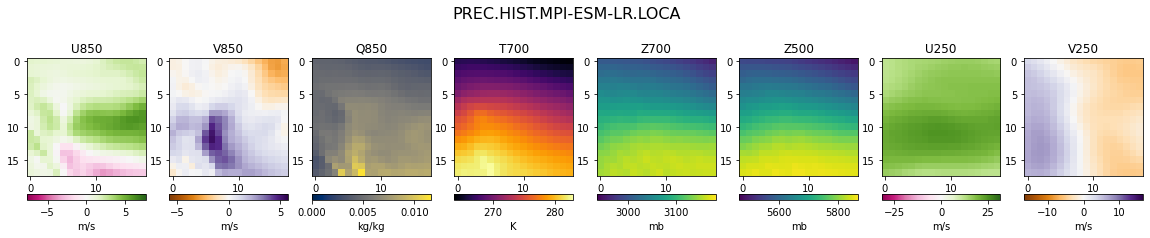

days: 425 , model: prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc


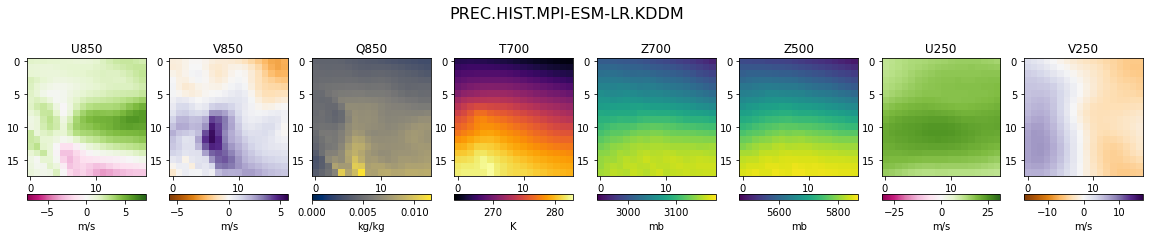

days: 342 , model: prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc


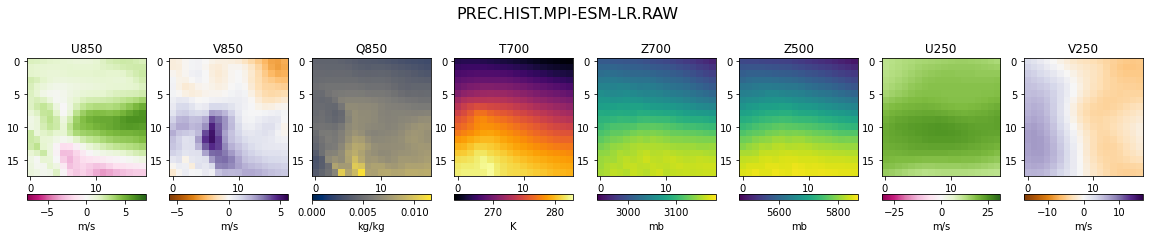

days: 485 , model: prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc


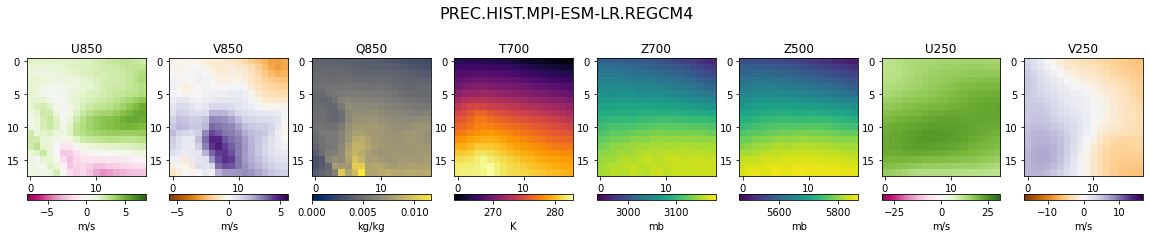

days: 436 , model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc


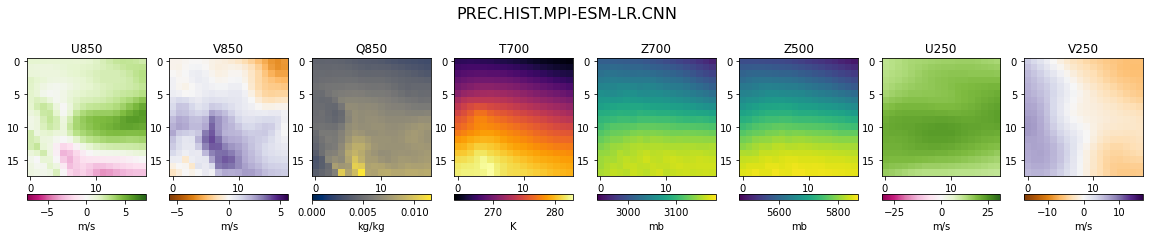

days: 446 , model: prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc


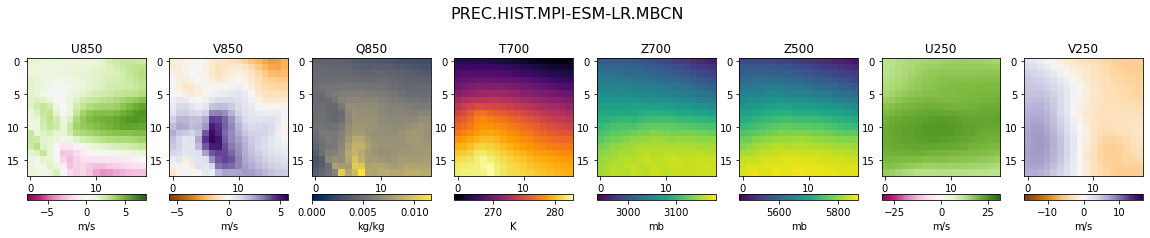

days: 284 , model: prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc


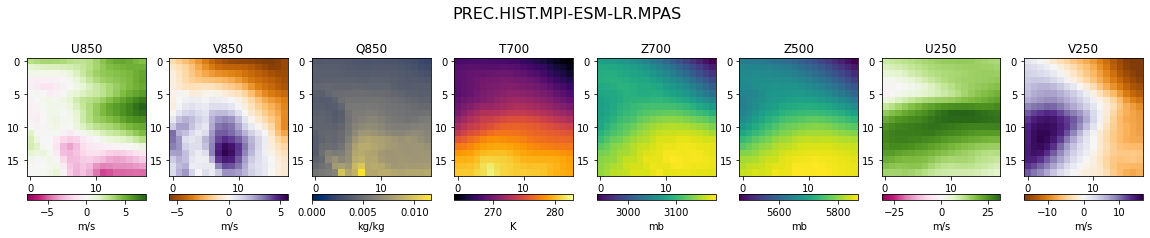

days: 305 , model: prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc


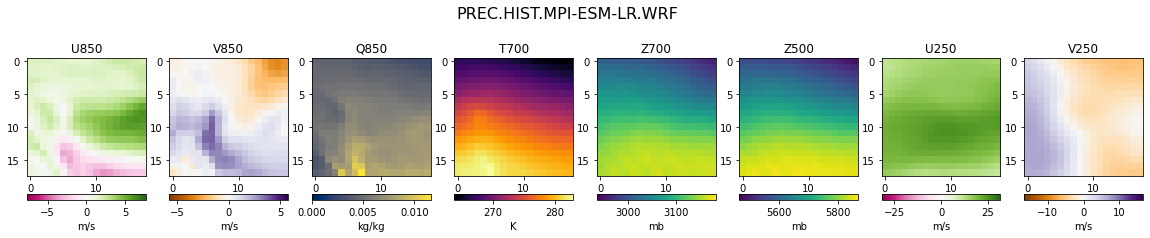

dry: rcp85
days: 462 , model: prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc


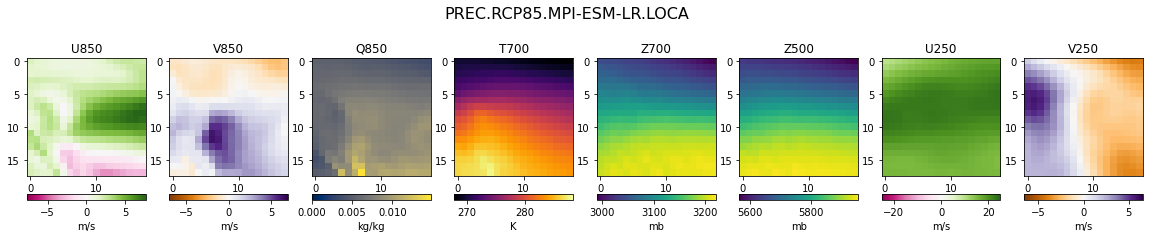

days: 500 , model: prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc


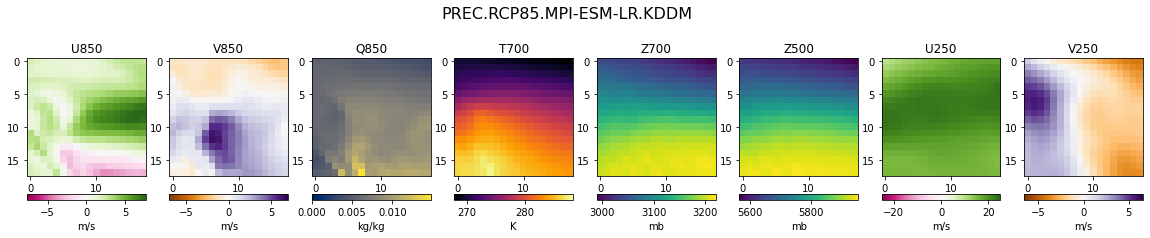

days: 421 , model: prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc


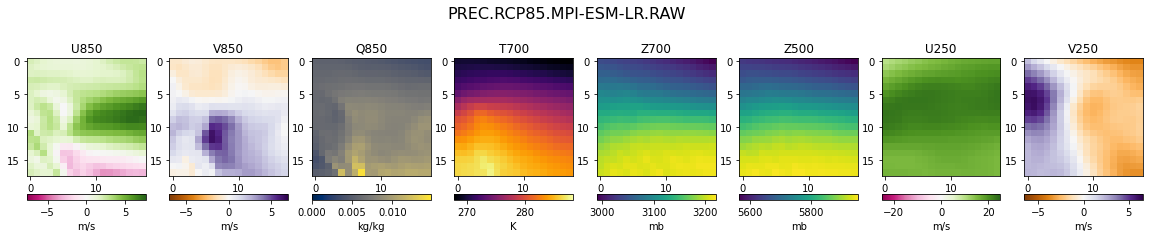

days: 460 , model: prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc


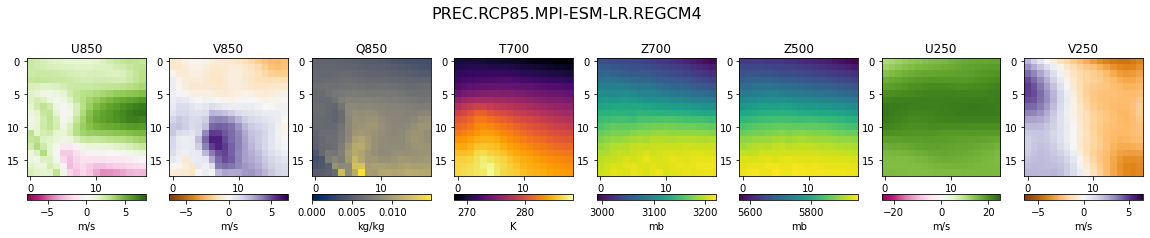

days: 456 , model: prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc


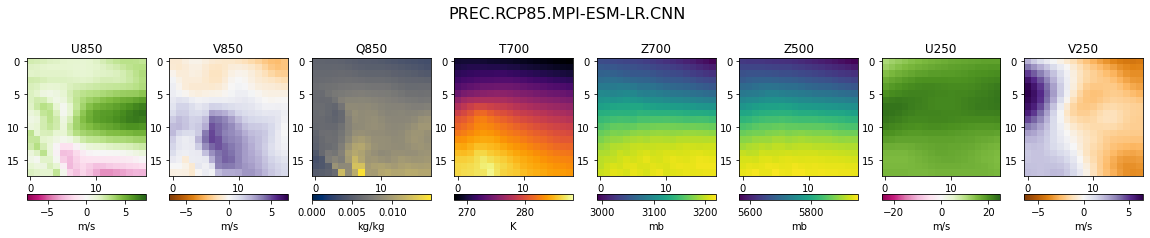

days: 487 , model: prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc


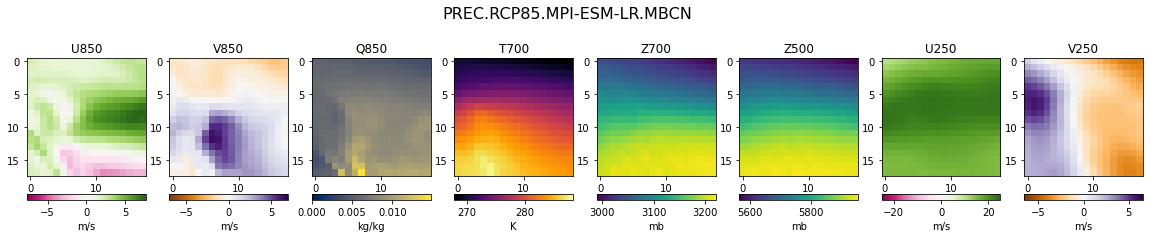

days: 305 , model: prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc


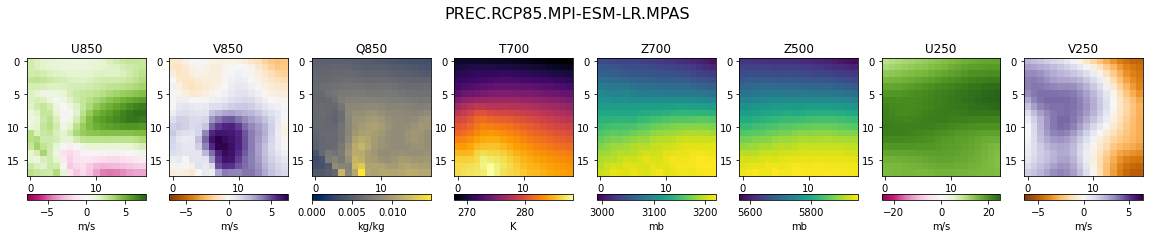

days: 350 , model: prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc


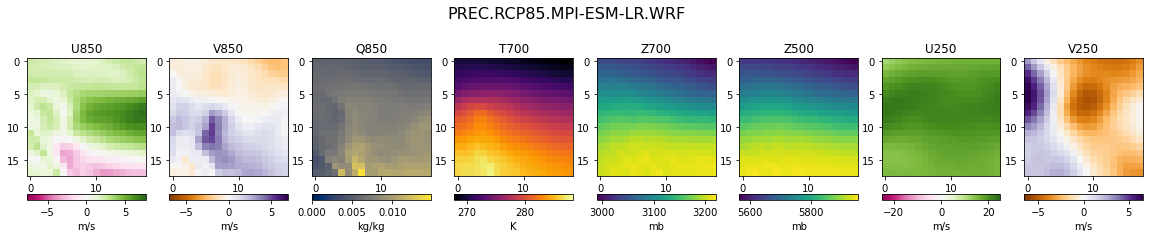

In [12]:
# mpi dry: hist
print("dry: hist")
sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles))
plot_models(0, 0.254, sigfiles_hist)

# mpi dry: rcp85
print("dry: rcp85")
sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, sigfiles))
plot_models(0, 0.254, sigfiles_rcp85)


# Moist day plots (hist and rcp85)

moist: hist
days: 192 , model: prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc


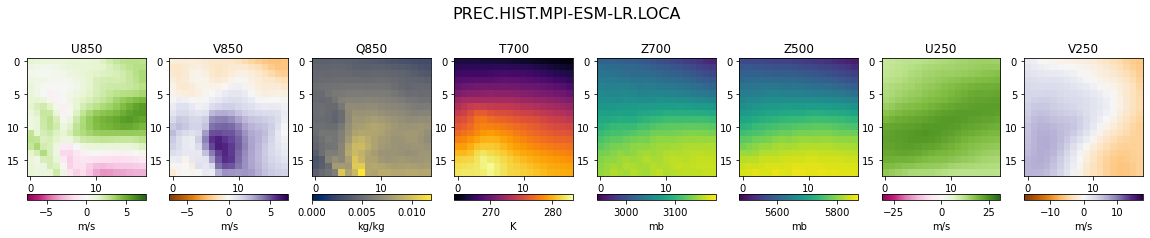

days: 147 , model: prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc


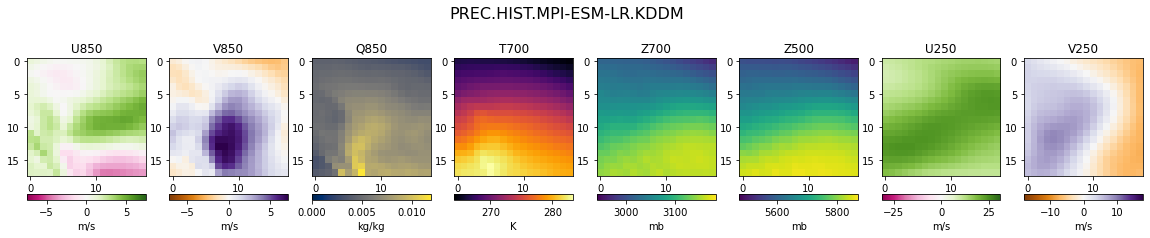

days: 210 , model: prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc


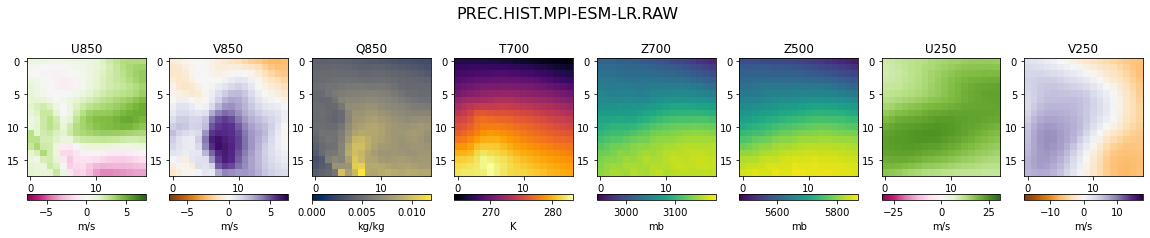

days: 142 , model: prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc


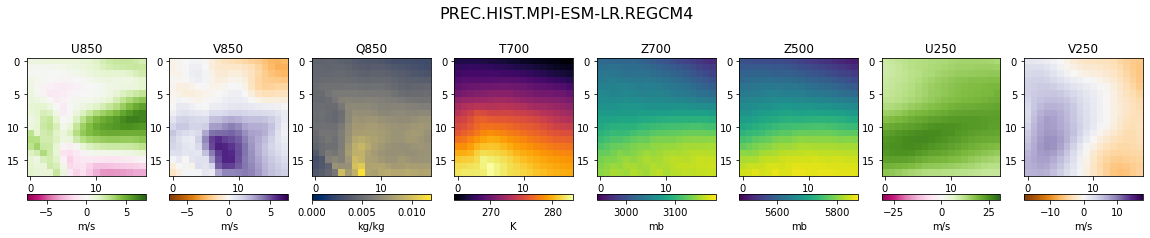

days: 179 , model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc


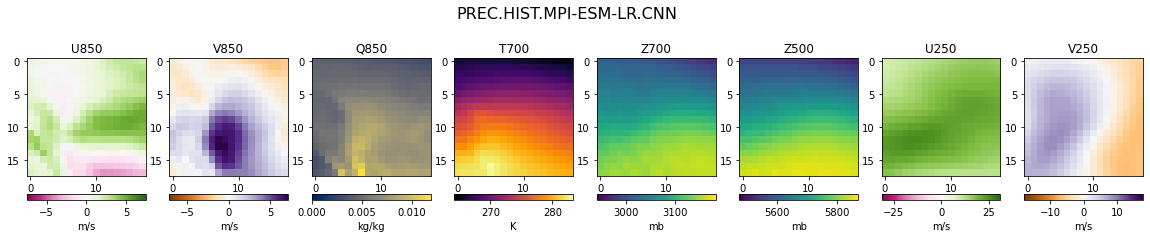

days: 143 , model: prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc


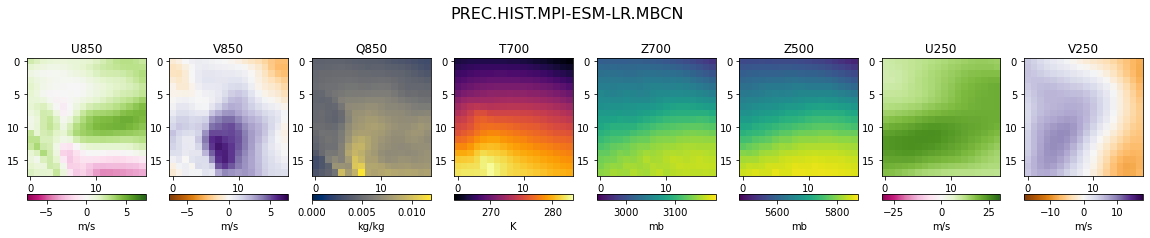

days: 207 , model: prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc


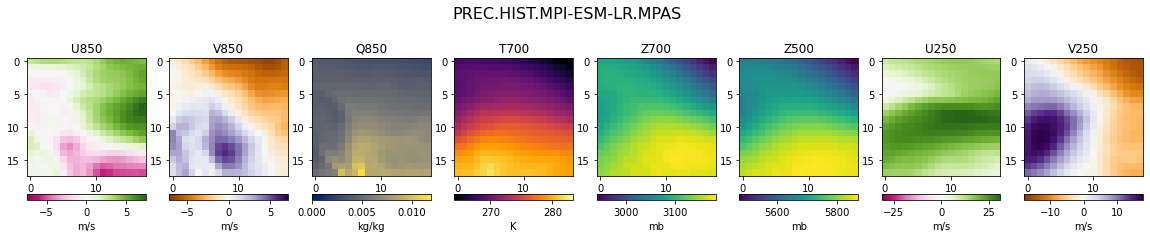

days: 188 , model: prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc


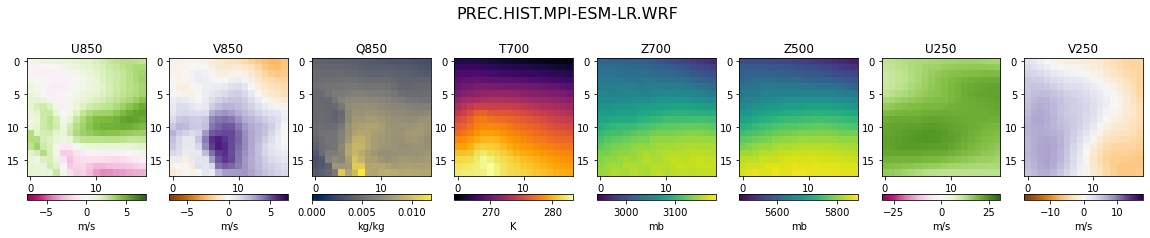

moist: rcp85
days: 131 , model: prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc


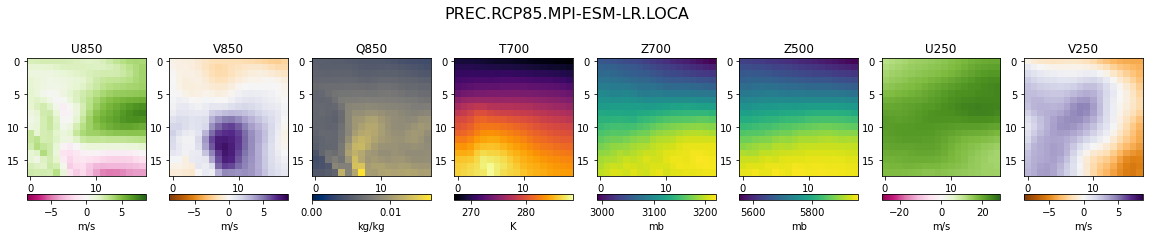

days: 105 , model: prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc


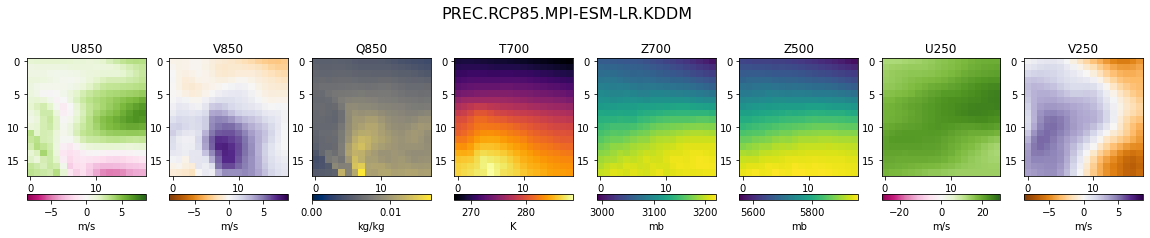

days: 166 , model: prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc


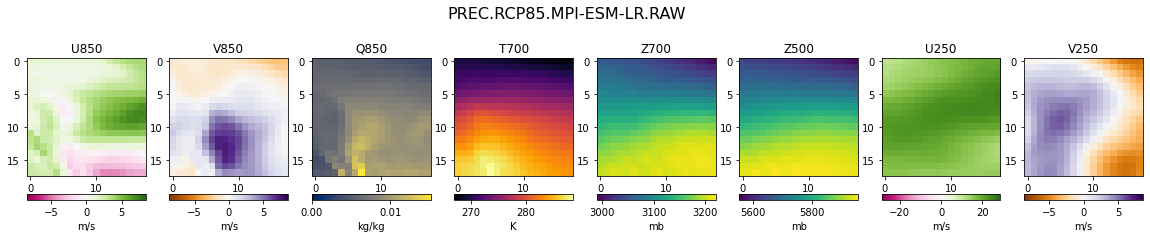

days: 134 , model: prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc


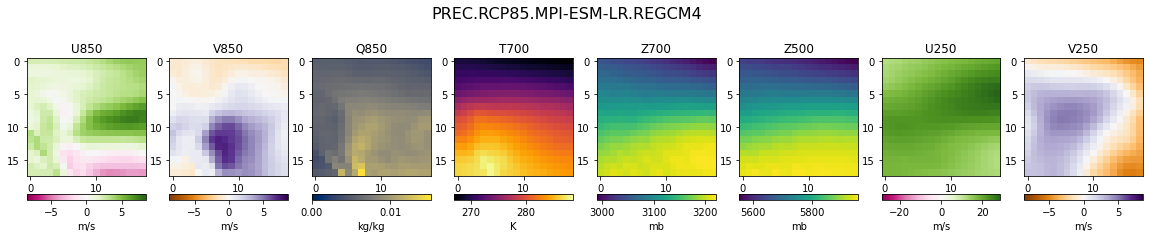

days: 159 , model: prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc


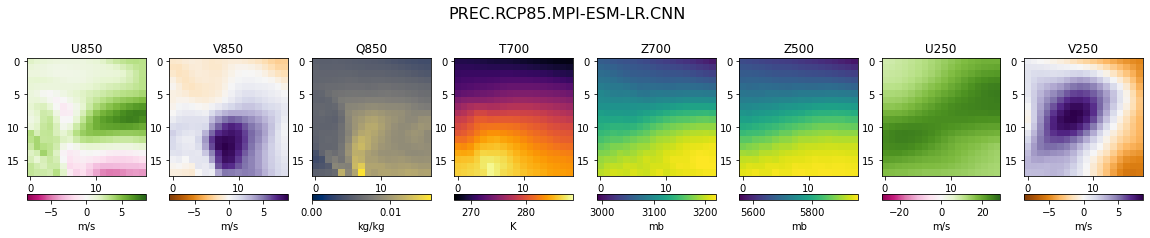

days: 120 , model: prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc


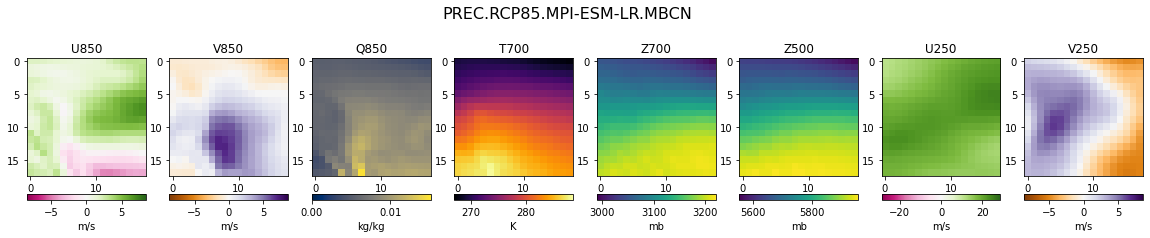

days: 193 , model: prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc


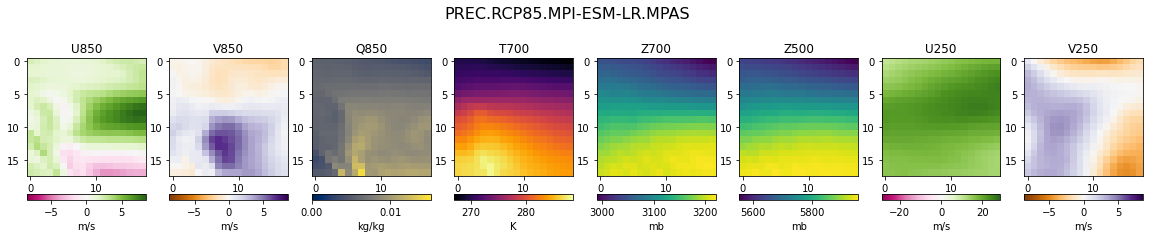

days: 140 , model: prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc


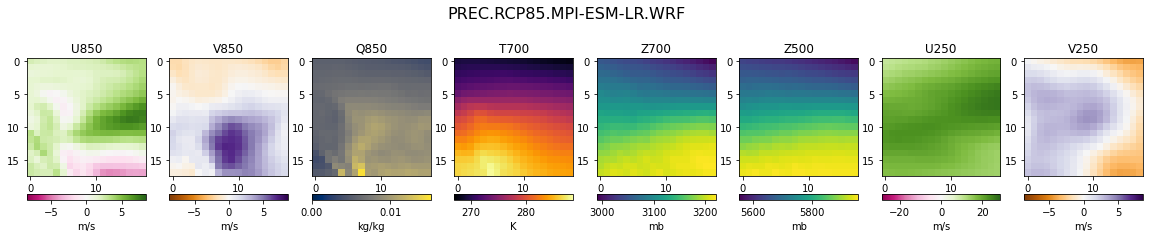

In [13]:
# mpi moist: hist
print("moist: hist")
sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles))
plot_models(0.254, 3.0, sigfiles_hist)

# mpi moist: rcp85
print("moist: rcp85")
sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, sigfiles))
plot_models(0.254, 3.0, sigfiles_rcp85)



# Wet day plots (hist and rcp85)

wet: hist
days: 256 , model: prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc


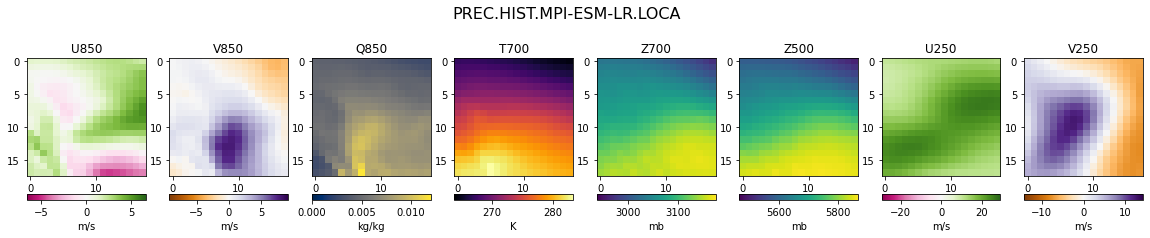

days: 234 , model: prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc


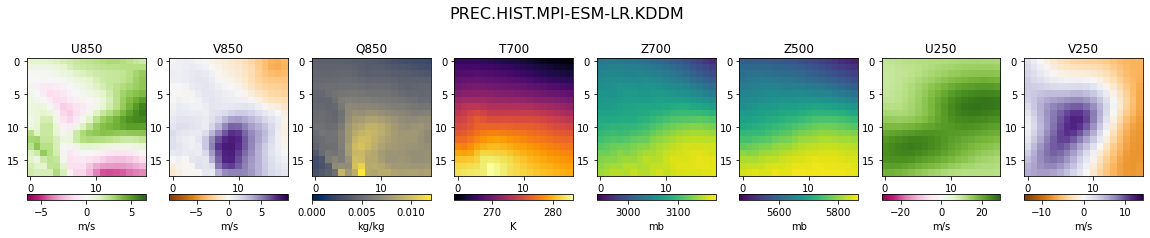

days: 254 , model: prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc


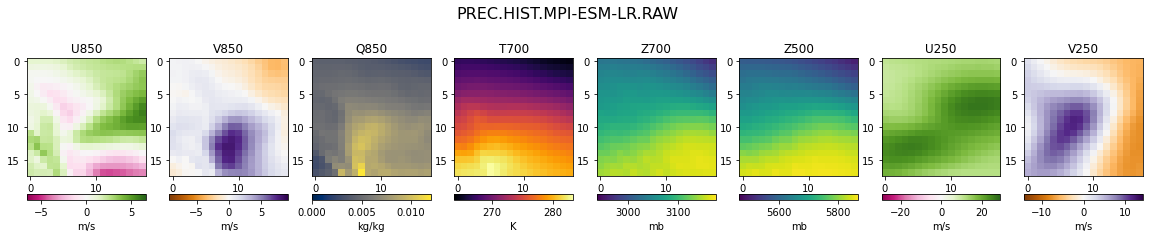

days: 179 , model: prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc


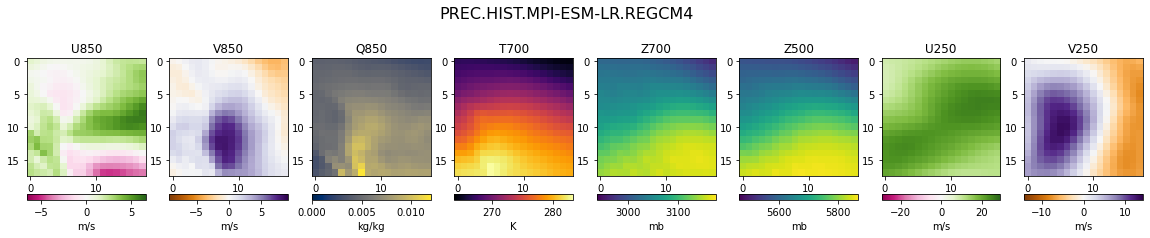

days: 190 , model: prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc


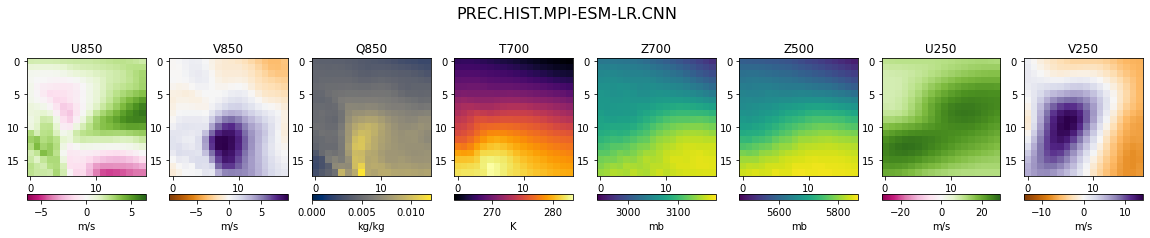

days: 217 , model: prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc


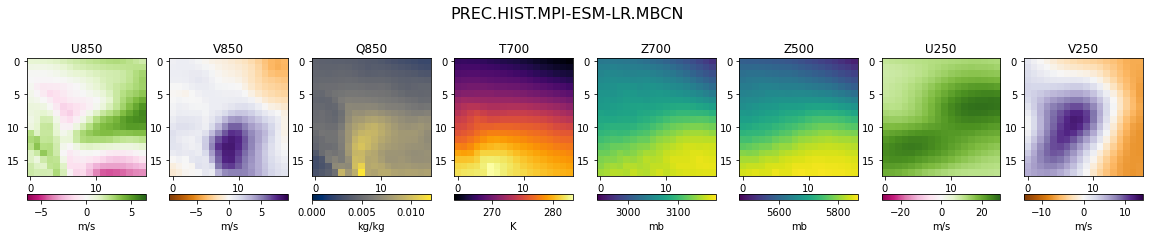

days: 191 , model: prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc


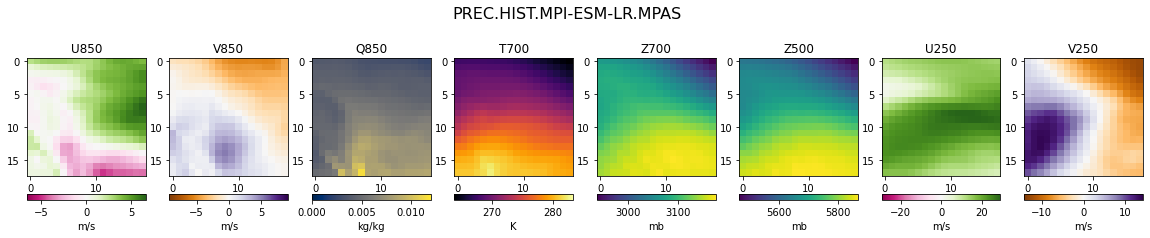

days: 313 , model: prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc


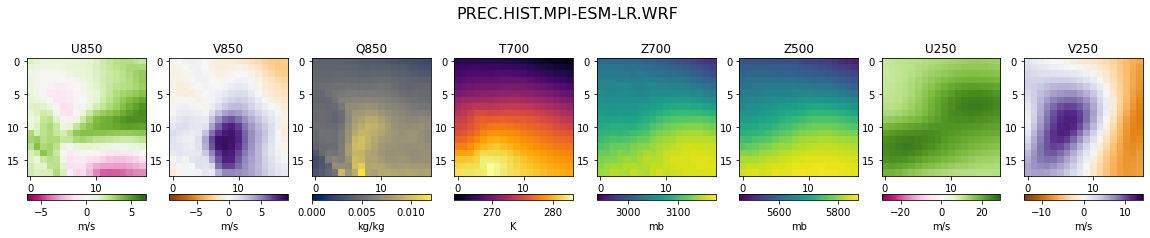

wet: rcp85
days: 213 , model: prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc


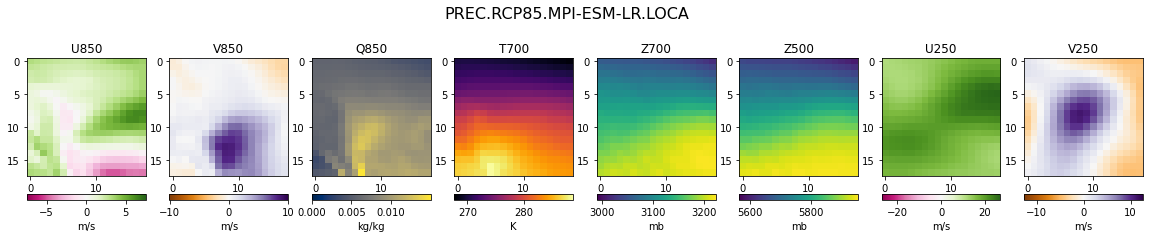

days: 201 , model: prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc


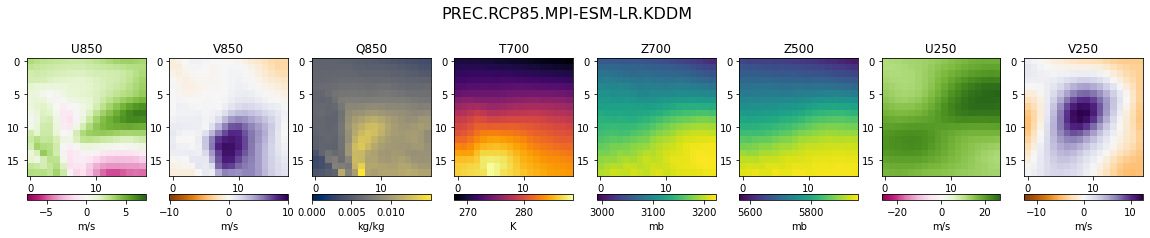

days: 219 , model: prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc


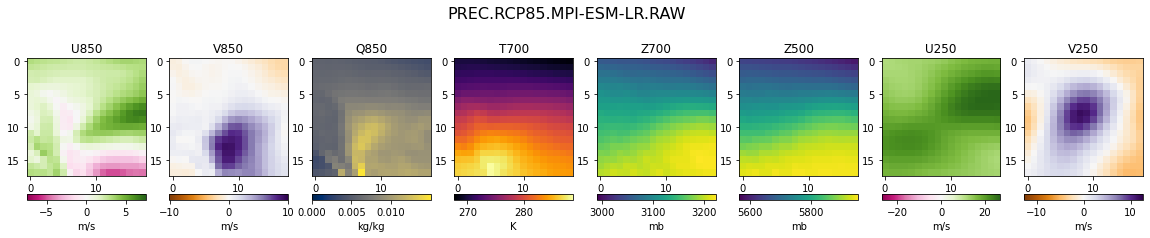

days: 212 , model: prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc


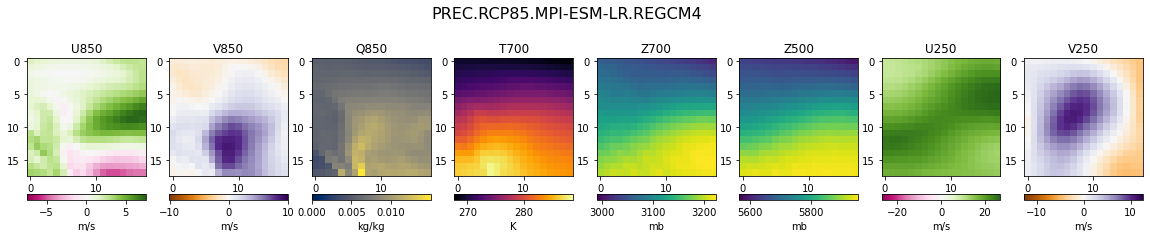

days: 177 , model: prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc


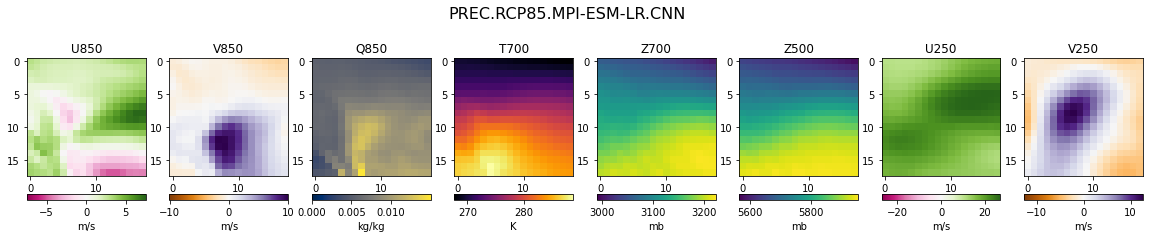

days: 199 , model: prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc


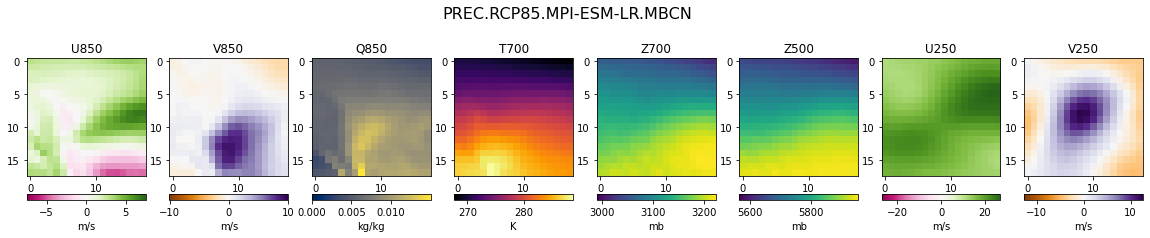

days: 184 , model: prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc


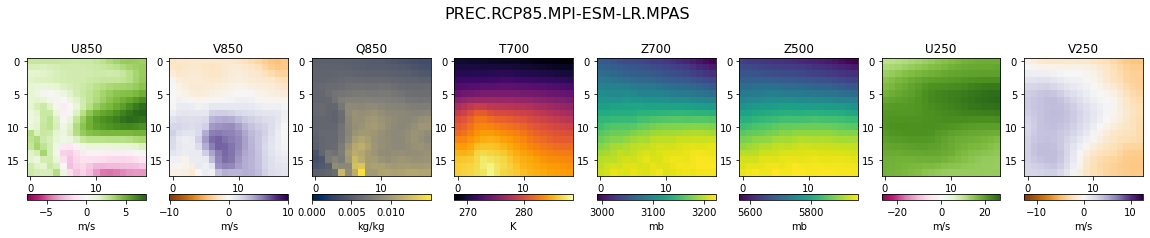

days: 316 , model: prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc


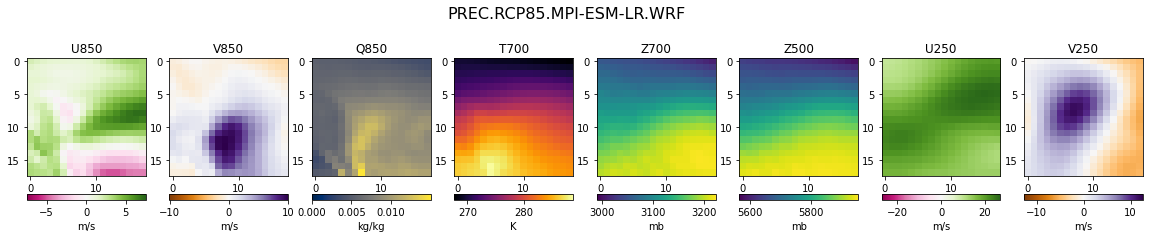

In [14]:
# mpi wet: hist
print("wet: hist")
sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles))
plot_models(3.0, 9999.0, sigfiles_hist)

# mpi wet: rcp85
print("wet: rcp85")
sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, sigfiles))
plot_models(3.0, 9999.0, sigfiles_rcp85)



# Selected models of interest (using autoscale)

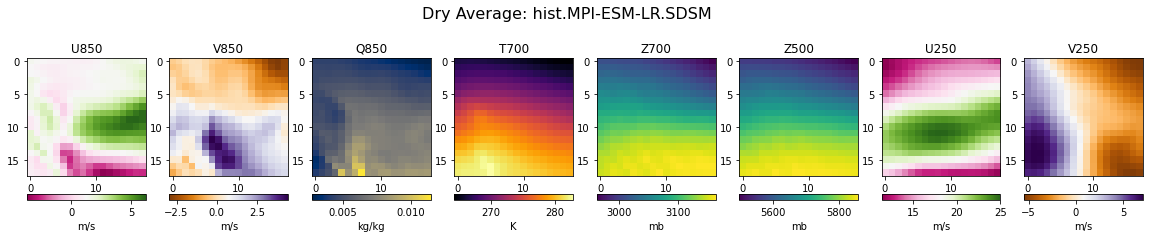

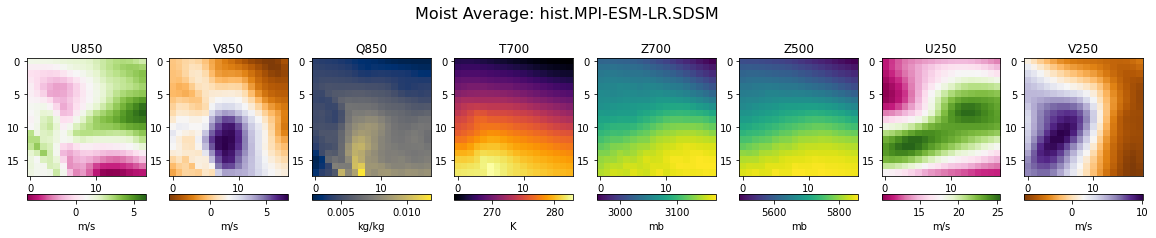

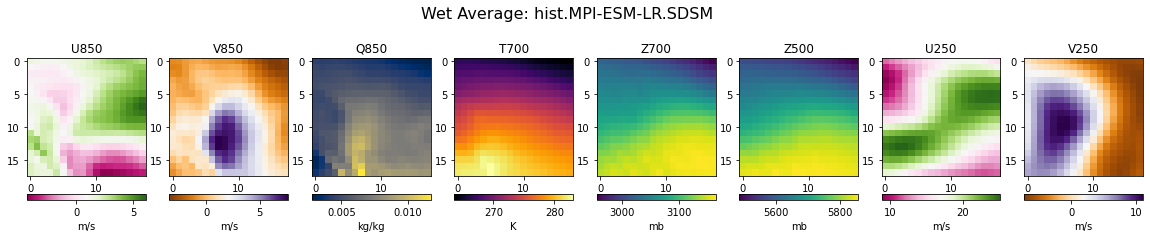

In [15]:
# MPI+sdsm: hist
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/new-sdsm/old/mpi/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc')['prec']
load_uatm_mpi_hist()
dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal) 
moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal) 
wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal) 
plot_8v_autoscale(dryinput, 'Dry Average: hist.MPI-ESM-LR.SDSM')
plot_8v_autoscale(moistinput, 'Moist Average: hist.MPI-ESM-LR.SDSM')
plot_8v_autoscale(wetinput, 'Wet Average: hist.MPI-ESM-LR.SDSM')


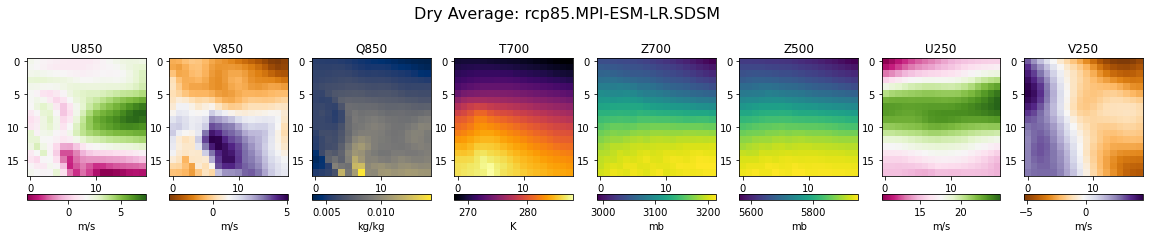

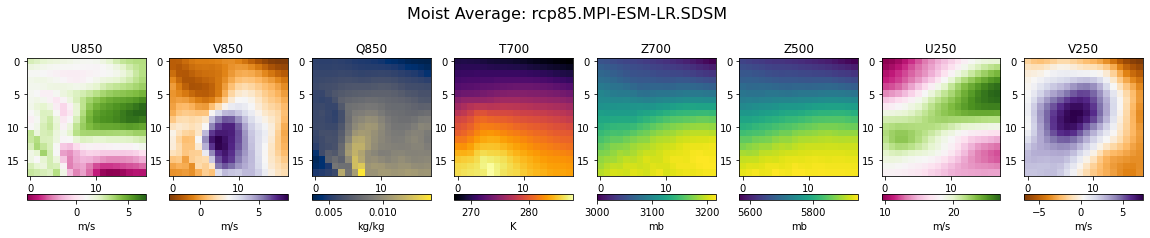

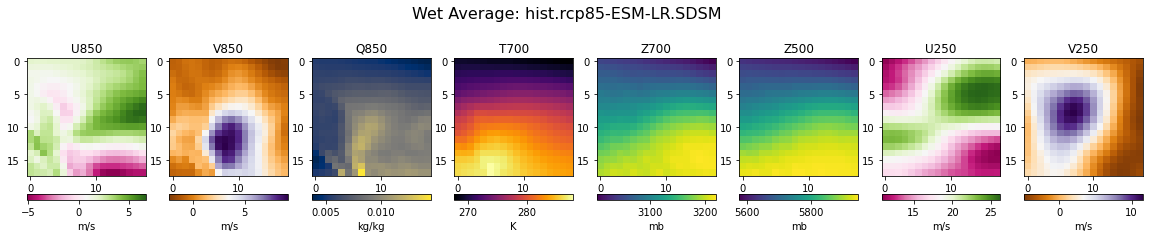

In [16]:
# MPI+sdsm: future
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/new-sdsm/old/mpi/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2100.NAM-22i.SGP.x098.y36.nc')['prec']
load_uatm_mpi_future()
dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal) 
moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal) 
wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal) 
plot_8v_autoscale(dryinput, 'Dry Average: rcp85.MPI-ESM-LR.SDSM')
plot_8v_autoscale(moistinput, 'Moist Average: rcp85.MPI-ESM-LR.SDSM')
plot_8v_autoscale(wetinput, 'Wet Average: hist.rcp85-ESM-LR.SDSM')


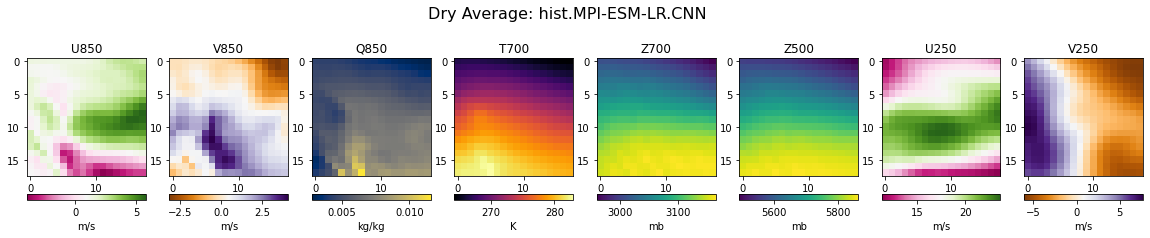

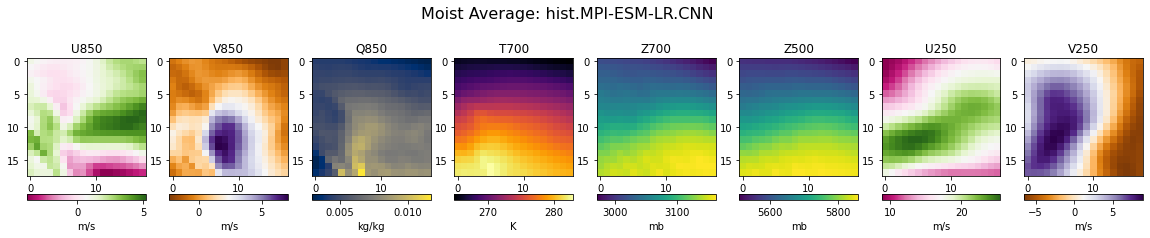

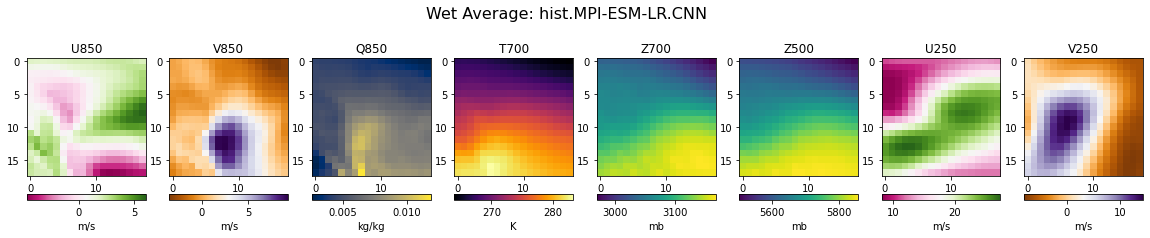

In [17]:
# MPI+cnn: hist
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']
load_uatm_mpi_hist()
dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal) 
moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal) 
wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal) 
plot_8v_autoscale(dryinput, 'Dry Average: hist.MPI-ESM-LR.CNN')
plot_8v_autoscale(moistinput, 'Moist Average: hist.MPI-ESM-LR.CNN')
plot_8v_autoscale(wetinput, 'Wet Average: hist.MPI-ESM-LR.CNN')


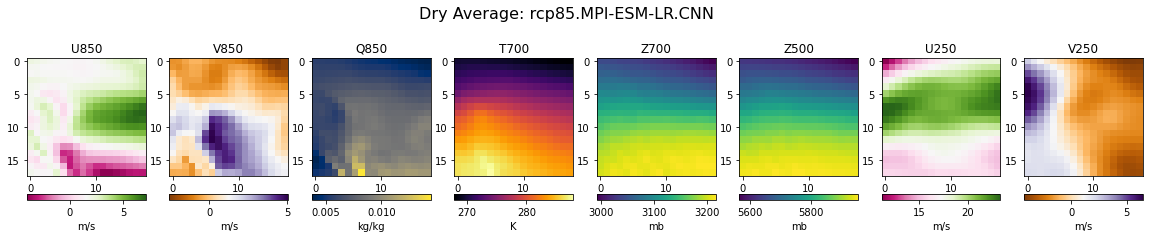

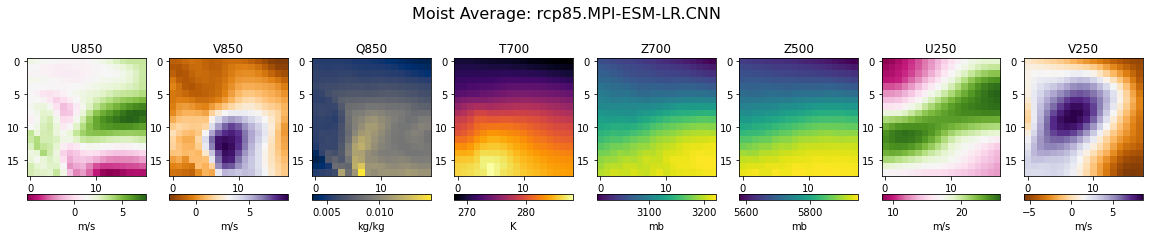

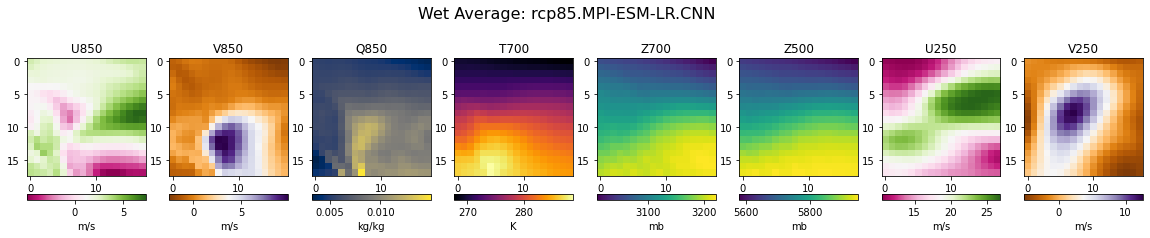

In [18]:
# MPI+cnn: rcp85
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc')['prec']
load_uatm_mpi_future()
dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal) 
moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal) 
wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal) 
plot_8v_autoscale(dryinput, 'Dry Average: rcp85.MPI-ESM-LR.CNN')
plot_8v_autoscale(moistinput, 'Moist Average: rcp85.MPI-ESM-LR.CNN')
plot_8v_autoscale(wetinput, 'Wet Average: rcp85.MPI-ESM-LR.CNN')


### Erai + obs

Days loaded 13515


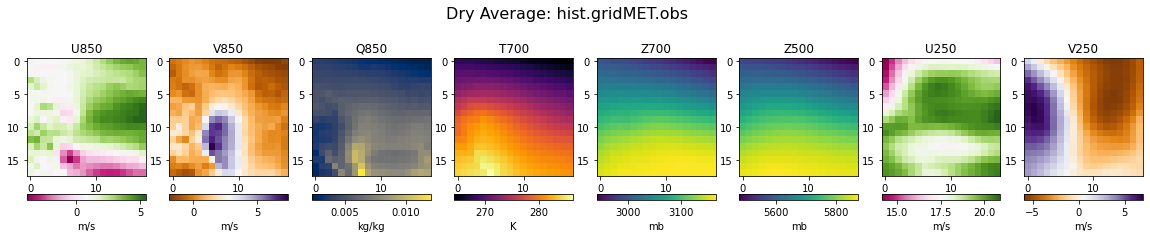

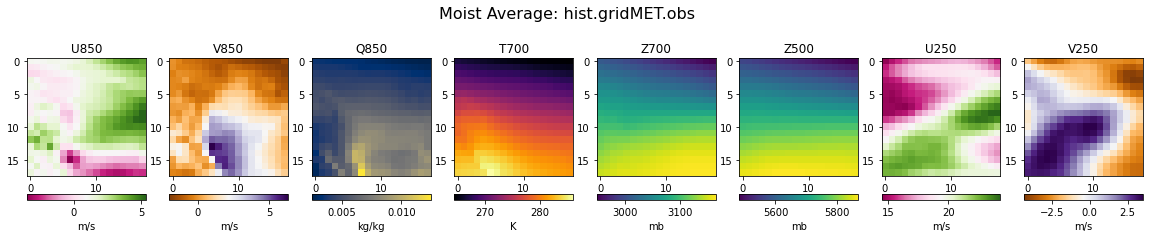

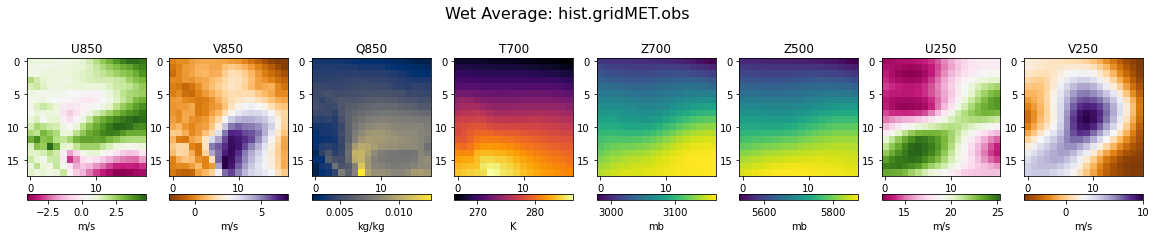

In [19]:
# Eraint+gridmet: hist
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']
load_uatm_erai()
dryinput, drycount, drydistribution, dryindices = calc_uatm_average(0, 0.254, rainsignal) 
moistinput, moistcount, moistdistribution, moistindices = calc_uatm_average(0.254, 3.0, rainsignal) 
wetinput, wetcount, wetdistribution, wetindices = calc_uatm_average(3.0, 9999.0, rainsignal) 
plot_8v_autoscale(dryinput, 'Dry Average: hist.gridMET.obs')
plot_8v_autoscale(moistinput, 'Moist Average: hist.gridMET.obs')
plot_8v_autoscale(wetinput, 'Wet Average: hist.gridMET.obs')


# SGP.x098.y36 vs. SPG
### Observation: rainsignal has larger extreme days than the SDG mean

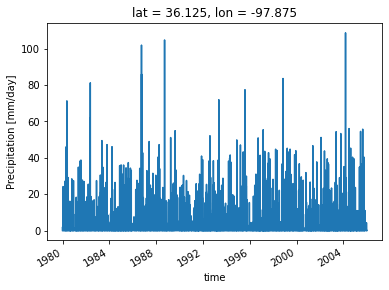

In [20]:
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']
rainsignal.plot()

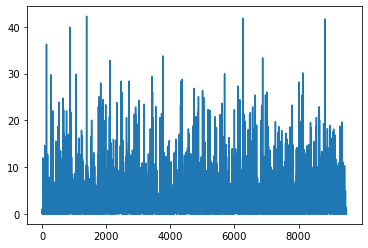

In [21]:
r2 = [dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean() for ii in range(len(dv1))][0:9497]
x = range(len(r2))
plt.plot(x, r2)


# missing data

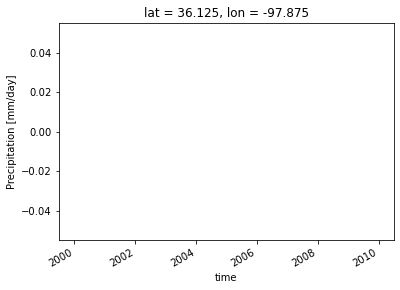

In [22]:
rainsignal = xr.open_dataset('/glade/work/mcginnis/DCA/data/gen/final/glm/hist/prec.hist.MPI-ESM-LR.GLM.day.1980-2005.NAM-22i.SGP.x098.y36.nc')['prec']
rainsignal.plot()

